# livedoor-news-5classification by multilingual-BERT

## 1. Import library

In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"

In [ ]:
import os
import h5py
import time
import glob
import json
import csv
import datetime
import random
import string
import pickle
import imageio
import cv2
import re
import sys
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import tensorflow_text as text 
#from tensorflow_docs.vis import embed
from tensorflow.keras import layers, Sequential, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm

from IPython.display import Image
%matplotlib inline

tf.random.set_seed(200) 

tf.__version__

'2.8.0'

## 2. Load livedoor-news-data


In [ ]:
train_df = pd.read_csv("train5.tsv", delimiter='\t', header=None, names=['label', 'title'])
train_df

,label,title
0,0,"月額1,050円でSASディスクを搭載！クラウドプラン 「エクスライト（EX-LITE）」の..."
1,0,例のあのメニューも！ニコニコ超会議のフードコートメニュー14種類紹介（前半）
2,1,山田孝之と小西真奈美の映画に撮影していない“あるモノ”が映り込んでいた
3,0,ガガを聴きながら毎朝歯磨き！ レディー・ガガ シンギングトゥースブラシ独占先行販売
4,2,斎藤佑樹はプロで通用するのか？
...,...,...
3498,1,美女たちがドレスの競演をした東京国際映画祭！スケスケのシースルー衣装を着たセクシー女優も
3499,2,プロアマ問題に怒り心頭のノムさん、都知事選には「俺でもいけそう」
3500,3,【オトナ女子のリアルな悩み】バツイチでは恋はできませんか？
3501,2,丸山桂里奈、なでしこジャパンのゴールに笑顔なく「すごく複雑な気持ち」


In [ ]:
test_df = pd.read_csv("dev5.tsv", delimiter='\t', header=None, names=['label', 'title'])
test_df

,label,title
0,4,ドコモのｓｐモードでまたトラブル発生！ 今度はつながらない【話題】
1,2,ダルビッシュ、今季だけで3つの魔球体得へ
2,1,本格的に仕事復帰、マリエが今一番会いたい人は“スギちゃん”
3,0,価格が安価で矯正を気づかれない！綺麗な歯並びになれる、歯列矯正の最前線
4,2,先輩・桑田、松井秀喜にズバリ「引退とかは考えなかった？」
...,...,...
871,2,三浦皇成、ほしのあきとの交際認める
872,3,【オトナ女子コミック部】すべての女は“ブス”である。女の毒素が臭気を放つコミックエッセイ『だ...
873,4,気をつけて！ スマートフォン、海外パケット定額プランのつもりが約100万円！のナゾ【話題】
874,4,KDDIがiPhone向けアプリ「auお客さまサポート」 をリリース【話題】


In [ ]:
max_seq_length=50
train_text = train_df['title'].tolist()
train_text = [' '.join(t.split()[0:max_seq_length]) for t in train_text]
train_text = np.array(train_text, dtype=object)
train_label = train_df['label'].tolist()

test_text = test_df["title"].tolist()
test_text = [' '.join(t.split()[0:max_seq_length]) for t in test_text]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = test_df['label'].tolist()

## 3. Prepare training and test data


In [ ]:
X_train_raw=train_df.loc[:, 'title']
X_train_raw=np.array(X_train_raw)

print(X_train_raw.dtype)
print(type(X_train_raw))
print(np.shape(X_train_raw))
print(X_train_raw[0:3])

object
<class 'numpy.ndarray'>
(3503,)
['月額1,050円でSASディスクを搭載！クラウドプラン 「エクスライト（EX-LITE）」の魅力を探る'
 '例のあのメニューも！ニコニコ超会議のフードコートメニュー14種類紹介（前半）'
 '山田孝之と小西真奈美の映画に撮影していない“あるモノ”が映り込んでいた']


In [ ]:
y_train=train_df.loc[:, 'label']
y_train=np.array(y_train)

print(y_train.dtype)
print(type(y_train))
print(np.shape(y_train))
print(y_train[0:3])

int64
<class 'numpy.ndarray'>
(3503,)
[0 0 1]


In [ ]:
X_test_raw=test_df.loc[:, 'title']
X_test_raw=np.array(X_test_raw)

print(X_test_raw.dtype)
print(type(X_test_raw))
print(np.shape(X_test_raw))
print(X_test_raw[0:3])

object
<class 'numpy.ndarray'>
(876,)
['ドコモのｓｐモードでまたトラブル発生！\u3000今度はつながらない【話題】' 'ダルビッシュ、今季だけで3つの魔球体得へ'
 '本格的に仕事復帰、マリエが今一番会いたい人は“スギちゃん”']


In [ ]:
y_test=test_df.loc[:, 'label']
y_test=np.array(y_test)

print(y_test.dtype)
print(type(y_test))
print(np.shape(y_test))
print(y_test[0:3])

int64
<class 'numpy.ndarray'>
(876,)
[4 2 1]


##  4. Build BERT model

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4",
    trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].
feature_extractor = tf.keras.Model(text_input, pooled_output)

In [ ]:
feature_extractor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['input_1[0][0]']                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

### Check how it works 

In [ ]:
sentences = tf.constant(["ありがとうございます","Thank you!"])
print(feature_extractor(sentences).shape)
feature_extractor(sentences)

(2, 768)


<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[ 0.3298394 , -0.24012822,  0.45697162, ..., -0.47372848,
         0.39084405,  0.30871463],
       [ 0.24569952,  0.10111848,  0.1490719 , ..., -0.16585767,
         0.18861838,  0.14410552]], dtype=float32)>

## 5. Extract features

In [ ]:
t=time.time()

X_train = feature_extractor(X_train_raw)

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')

print((X_train).shape)
X_train

158.80482 Seconds to predict
(3503, 768)


<tf.Tensor: shape=(3503, 768), dtype=float32, numpy=
array([[ 0.24110281, -0.00477027,  0.3722781 , ..., -0.34266132,
         0.24451429,  0.26786855],
       [ 0.37611768, -0.08474807,  0.3083135 , ..., -0.23839931,
         0.20487688,  0.16242209],
       [ 0.39279768, -0.1714481 ,  0.3055103 , ..., -0.47528455,
         0.24804725,  0.24116442],
       ...,
       [ 0.4324022 ,  0.09242747,  0.33599386, ..., -0.4236296 ,
         0.21504761,  0.11122373],
       [ 0.40475598,  0.04343591,  0.2340132 , ..., -0.18150666,
         0.08990388,  0.10266212],
       [ 0.43208796, -0.16266476,  0.3027273 , ..., -0.33386615,
         0.29739547,  0.28396392]], dtype=float32)>

In [ ]:
t=time.time()

X_test = feature_extractor(X_test_raw)

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')

print((X_test).shape)
X_test

38.50877 Seconds to predict
(876, 768)


<tf.Tensor: shape=(876, 768), dtype=float32, numpy=
array([[ 0.22848426,  0.08317668,  0.26285738, ..., -0.14897172,
         0.21719557,  0.01571667],
       [ 0.3130742 , -0.03618056,  0.24547513, ..., -0.2627665 ,
         0.14594346,  0.10071204],
       [ 0.2933034 , -0.0561115 ,  0.36557746, ..., -0.34519538,
         0.26619253,  0.06667342],
       ...,
       [ 0.37434772,  0.04100348,  0.27414072, ..., -0.02412987,
         0.2875718 ,  0.05480246],
       [ 0.37936074, -0.04082596,  0.30807906, ..., -0.16299853,
         0.29364198,  0.24983805],
       [ 0.26637626, -0.14480269,  0.23917629, ..., -0.13616604,
         0.0543225 ,  0.09414471]], dtype=float32)>

## 6. Train the classifier

In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=768, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

optimizer = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                12304     
                                                                 
 dense_1 (Dense)             (None, 5)                 85        
                                                                 
Total params: 12,389
Trainable params: 12,389
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
t=time.time()

history = model.fit(X_train, y_train, epochs=2000, batch_size=512, validation_split=0.1, verbose=1)

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')

Epoch 1/2000
7/7 [==============================] - 1s 37ms/step - loss: 1.7465 - accuracy: 0.2018 - val_loss: 1.7030 - val_accuracy: 0.1937
Epoch 2/2000
7/7 [==============================] - 0s 8ms/step - loss: 1.6829 - accuracy: 0.2059 - val_loss: 1.6572 - val_accuracy: 0.1880
Epoch 3/2000
7/7 [==============================] - 0s 6ms/step - loss: 1.6451 - accuracy: 0.2005 - val_loss: 1.6274 - val_accuracy: 0.1880
Epoch 4/2000
7/7 [==============================] - 0s 5ms/step - loss: 1.6218 - accuracy: 0.1888 - val_loss: 1.6073 - val_accuracy: 0.1795
Epoch 5/2000
7/7 [==============================] - 0s 5ms/step - loss: 1.6079 - accuracy: 0.1872 - val_loss: 1.5959 - val_accuracy: 0.2023
Epoch 6/2000
7/7 [==============================] - 0s 8ms/step - loss: 1.6009 - accuracy: 0.1935 - val_loss: 1.5908 - val_accuracy: 0.2222
Epoch 7/2000
7/7 [==============================] - 0s 6ms/step - loss: 1.5965 - accuracy: 0.1977 - val_loss: 1.5876 - val_accuracy: 0.2279
Epoch 8/2000
7/7 [=

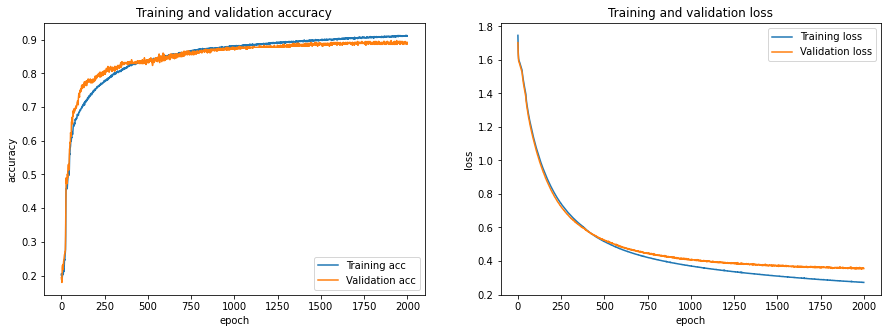

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
            
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.show()

## 7. Evaluate the model

In [ ]:
loss, accuracy = model.evaluate(X_test,y_test)
print("\nloss:{} accuracy:{}".format(loss, accuracy))

28/28 [==============================] - 0s 2ms/step - loss: 0.3625 - accuracy: 0.8744

loss:0.36246824264526367 accuracy:0.8744292259216309
